## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from IPython.display import clear_output
import random
import time

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('/kaggle/input/sonnnets/sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('/kaggle/input/sonnnets/sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = "".join([t.lower() for t in text])
# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
chars = sorted(list(set(text)))
VOCAB_SIZE = len(chars)
print("Размер словаря:", VOCAB_SIZE)

Размер словаря: 38


Размер словаря: 38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
id2char = {i: ch for i, ch in enumerate(chars)}
# dict <char>:<index>
char2id = {ch: i for i, ch in enumerate(chars)}
# Your great code here

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [6]:
SEQ_LENGTH = 200
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 256
TEXT_LENGTH = len(text)
RANDOM_SEED = 2025
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
random.seed(RANDOM_SEED)

def random_portion(text):
    start_index = random.randint(0, TEXT_LENGTH - SEQ_LENGTH)
    end_index = start_index + SEQ_LENGTH + 1
    return text[start_index:end_index]

print(random_portion(text))

 my mind;
  and that which governs me to go about
  doth part his function and is partly blind,
  seems seeing, but effectually is out;
  for it no form delivers to the heart
  of bird, of flower, or s


In [8]:
def char_to_tensor(text):
    chars = [char2id[c] for c in text]
    tensor = torch.tensor(chars).long()
    return tensor

print(char_to_tensor('my mind'))

tensor([24, 36,  1, 24, 20, 25, 15])


In [9]:
def get_random_sample(text):    
    text_long = char_to_tensor(random_portion(text))
    inputs = text_long[:-1]
    targets = text_long[1:]
    return inputs, targets

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

Чтобы освежить память реализуем свою RNN. Для этого вспомним примерный принцпи работы:

$$h_n = tanh(h_{n-1}W_1 + x_{n}W_2)$$

$$y_n = h_nW_3$$

In [10]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size
        
        self.embed = torch.nn.Embedding(num_embeddings=input_size,
                                        embedding_dim=embed_size)
        self.rnn = torch.nn.RNNCell(input_size=embed_size,
                                     hidden_size=hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, character, hidden):
        embedded = self.embed(character)

        hidden = self.rnn(embedded, hidden)

        output = self.fc(hidden)

        return output, hidden
      
    def init_zero_state(self):
        init_hidden = torch.zeros(1, self.hidden_size).to(DEVICE)
        return init_hidden

In [11]:
def evaluate_rnn(model, prime_str: str, predict_len=128, temperature=0.8):
    model.eval()
    hidden = model.init_zero_state()
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        inp = prime_input[p].unsqueeze(0)
        _, hidden = model(inp.to(DEVICE), hidden)
    inp = prime_input[-1].unsqueeze(0)
    
    for p in range(predict_len):

        outputs, hidden = model(inp.to(DEVICE), hidden)
        
        logits = outputs.view(-1) / temperature
        probs = torch.softmax(logits, dim=0)
        top_i = torch.multinomial(probs, 1).item()
        
        predicted_char = id2char[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

In [12]:
def train_rnn(
    data,
    model,
    optimizer,
    n_samples,
    eval_steps=200,
    
):
    start_time = time.time()
    train_loss_history = []

    loss_cumsum = 0
    for iteration in range(n_samples):
    
        hidden = model.init_zero_state()
        optimizer.zero_grad()
    
        x, y = get_random_sample(data)
        x, y = x.to(DEVICE), y.to(DEVICE)
    
        loss = 0
        for c in range(SEQ_LENGTH):
            outputs, hidden = model(x[c].unsqueeze(0), hidden)
            loss += torch.nn.functional.cross_entropy(outputs, y[c].view(1))
    
        loss /= SEQ_LENGTH
        loss.backward()
        optimizer.step()
        loss_cumsum += loss.item()
        
        with torch.no_grad():
            if iteration % eval_steps == 0:
                # update loss
                if iteration != 0:
                    train_loss_history.append(loss_cumsum / eval_steps)
                loss_cumsum = 0
                # plot
                clear_output(wait=True)
                plt.figure(figsize=(8, 5))
                x_scaled = np.arange(1, len(train_loss_history)+1) * eval_steps
                plt.plot(x_scaled, train_loss_history, label="Train Loss")
                plt.xlabel("Iterations")
                plt.ylabel("Cross-Entropy Loss")
                plt.title("Training Loss")
                plt.legend()
                plt.grid(True)
                plt.show()
                # generate
                print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
                print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
                print(evaluate_rnn(model, 'love is', SEQ_LENGTH), '\n')

    return train_loss_history

In [13]:
torch.manual_seed(RANDOM_SEED)
model = RNN(
    input_size=VOCAB_SIZE,
    embed_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=VOCAB_SIZE
)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

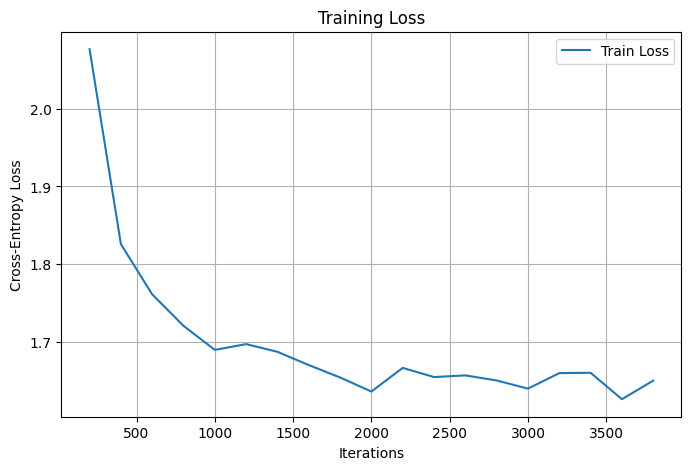

Time elapsed: 6.11 min
Iteration 3800 | Loss 1.40


love is dresparrof brage,
  to tell;
  so meauty other me will the were despass it the to eaw look of that thant due fartent's thou strong that detair,
  desterite.
  my look; by ravery thou anter that love, 



In [14]:
train_loss_history_rnn = train_rnn(
    data=text,
    model=model,
    optimizer=optimizer,
    n_samples=4000
)

Time elapsed: 7.82 min

Iteration 3800 | Loss 1.53


love is the be whe be but.

  make to me me some of sweets, angue,
  
  when the love the with's me love that be my reccip,
  
  lookes and to gant those be am thus out me so.' me swill face of self awance weed thy

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [15]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size
        
        self.embed = torch.nn.Embedding(num_embeddings=input_size,
                                        embedding_dim=embed_size)
        self.rnn = torch.nn.LSTMCell(input_size=embed_size,
                                     hidden_size=hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, character, hidden, cell_state):
        embedded = self.embed(character)

        (hidden, cell_state) = self.rnn(embedded, (hidden, cell_state))

        output = self.fc(hidden)

        return output, hidden, cell_state
      
    def init_zero_state(self):
        init_hidden = torch.zeros(1, self.hidden_size).to(DEVICE)
        init_cell = torch.zeros(1, self.hidden_size).to(DEVICE)
        return (init_hidden, init_cell)

In [25]:
def evaluate_lstm(model, prime_str: str, predict_len=128, temperature=0.8):
    model.eval()
    (hidden, cell_state) = model.init_zero_state()
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        inp = prime_input[p].unsqueeze(0)
        _, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
    inp = prime_input[-1].unsqueeze(0)
    
    for p in range(predict_len):

        outputs, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
        
        logits = outputs.view(-1) / temperature
        probs = torch.softmax(logits, dim=0)
        top_i = torch.multinomial(probs, 1).item()

        predicted_char = id2char[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

In [17]:
def train_lstm(
    data,
    model,
    optimizer,
    n_samples,
    eval_steps=200,
    
):
    start_time = time.time()
    train_loss_history = []

    loss_cumsum = 0
    for iteration in range(n_samples):
    
        hidden, cell_state = model.init_zero_state()
        optimizer.zero_grad()
    
        x, y = get_random_sample(data)
        x, y = x.to(DEVICE), y.to(DEVICE)
    
        loss = 0
        for c in range(SEQ_LENGTH):
            outputs, hidden, cell_state = model(x[c].unsqueeze(0), hidden, cell_state)
            loss += torch.nn.functional.cross_entropy(outputs, y[c].view(1))
    
        loss /= SEQ_LENGTH
        loss.backward()
        optimizer.step()
        loss_cumsum += loss.item()
        
        with torch.no_grad():
            if iteration % eval_steps == 0:
                # update loss
                if iteration != 0:
                    train_loss_history.append(loss_cumsum / eval_steps)
                loss_cumsum = 0
                # plot
                clear_output(wait=True)
                plt.figure(figsize=(8, 5))
                x_scaled = np.arange(1, len(train_loss_history)+1) * eval_steps
                plt.plot(x_scaled, train_loss_history, label="Train Loss")
                plt.xlabel("Iterations")
                plt.ylabel("Cross-Entropy Loss")
                plt.title("Training Loss")
                plt.legend()
                plt.grid(True)
                plt.show()
                # generate
                print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
                print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
                print(evaluate_lstm(model, 'love is', SEQ_LENGTH), '\n')

    return train_loss_history

In [18]:
torch.manual_seed(RANDOM_SEED)
model = LSTM(
    input_size=VOCAB_SIZE,
    embed_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=VOCAB_SIZE
)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

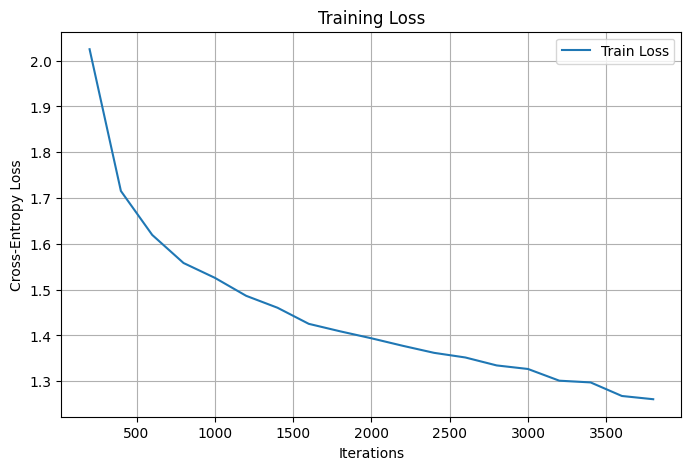

Time elapsed: 10.93 min
Iteration 3800 | Loss 1.27


love is beauty's show
    thou art i see their same in quest
  and do weeks'd winter out i character,
  on did not as pluck of your delights;
    thought do thou shouldst whope against thou bestain of commen 



In [19]:
train_loss_history_lstm = train_lstm(
    data=text,
    model=model,
    optimizer=optimizer,
    n_samples=4000
)

Plot the loss function of the number of epochs. Does the final loss become better?

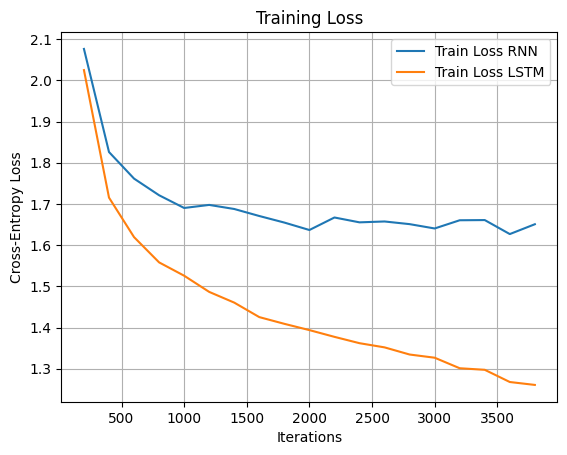

In [20]:
x_scaled = np.arange(1, len(train_loss_history_rnn)+1) * 200
plt.plot(x_scaled, train_loss_history_rnn, label="Train Loss RNN")
plt.plot(x_scaled, train_loss_history_lstm, label="Train Loss LSTM")
plt.xlabel("Iterations")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

*Из сравнения очевидно, что LSTM справляется лучше, так как трейн лосс сильно меньше. Связано с тем, что у LSTM как минимум больше параметров и она лучше запоминает длинные последовательности.*

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [26]:
model.eval()
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    predicted_text = evaluate_lstm(model, "love is", predict_len=SEQ_LENGTH, temperature=t)
    print("temperature = ", t)
    print("Generatede text\n", predicted_text)
    print("="*40)

temperature =  0.1
Generatede text
 love is the story shame doth shall best i see the summer's stand
  that thou shalt be so thou dost be so thou shalt i am forth.
    that thou shalt that which i will be so thou dost best i love the summer so
temperature =  0.2
Generatede text
 love is my love the summer that i will;
  and that i am desire is the shalt best i see the shape the dear where;
  and the summer and the story shall i see doth shall i will shall not to the will,
  and that
temperature =  0.5
Generatede text
 love is the destred:
  for are make me that to me i not shadows mind.
    simpon the sweet beauty's fix'd of thee,
  where you thy mort in the shadow's alone,
  and the painter's art, and the summer some in 
temperature =  1.0
Generatede text
 love is mayst hout
  as my love of hath more pleasure, or fair say,
  as time's weit kesion beauteous difledt pirchited:
  shall of stat's desert-axacce,
  and both for the that youth, of love,
  a see bode,
temperature =  2.0
Gener

Наилучший ответ получился при t = 0.5.

При очень низкой температуре мы выбираем самый вероятный токен и здесь это приводит к тому, что если смотреть отдельно по словам, то все выглядит неплохо, но если проверять осмысленность текста целиком(хотя бы словосочетания), то получаются абсолютно не связанные куски.

При очень высокой же температуре, модель просто начинает выбирать токены рандомно и получается бред. Даже адекватных слов не получаетсятся.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

Сохраняем веса модели

In [27]:
torch.save(model.state_dict(), "lstm.pt")

Создаем новую модель, при этом мы должны задать такую же архитектуру модели:

In [29]:
load_model = LSTM(
    input_size=VOCAB_SIZE,
    embed_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=VOCAB_SIZE
)

Загружаем веса

In [30]:
load_model.load_state_dict(torch.load("lstm.pt", weights_only=True))
load_model.eval()

LSTM(
  (embed): Embedding(38, 128)
  (rnn): LSTMCell(128, 256)
  (fc): Linear(in_features=256, out_features=38, bias=True)
)

In [32]:
generated_text = evaluate_lstm(model, "love is", predict_len=SEQ_LENGTH, temperature=0.5)
print(generated_text)

love is the summer's frame,
  that best lips nor the desired whereon the spend
  for that this thou not thou that i would despite with my sight,
  and where you despite on the summer to see,
    but is my lo


Все работает

В идеале еще в работе хотелось бы успеть валидацию настроить и показать, что на валидации метрики тоже выросли у LSTM и проверить вообще как быстро переобучаться, но уже сделать не успел.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)